# Exploratory Data Analysis

- [Accéder aux bases](https://www.data.gouv.fr/fr/datasets/bases-de-donnees-annuelles-des-accidents-corporels-de-la-circulation-routiere-annees-de-2005-a-2021/)
- [Accéder à la documentation](https://www.data.gouv.fr/fr/datasets/r/8ef4c2a3-91a0-4d98-ae3a-989bde87b62a)

# Objectifs : prédire la gravité d'un accident

La gravité d'un accident est codée par la variable `grav`, présente (uniquement) dans la base _usagers_, qui peut prendre les valeurs suivantes :
- 1 : indemne ;
- 2 : tué ;
- 3 : blessé hospitalisé ;
- 4 : blessé léger.

On charge dans un premier temps tous les packages nécessaires.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Sur data.gouv, quatre bases de données sont publiées annuellement. Elles concernent : les usages, les véhicules, les lieux et les caractéristiques. Nous chargeons ci-dessous les quatre bases de 2021 (les plus récentes).

In [2]:
df_usagers_22 = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/62c20524-d442-46f5-bfd8-982c59763ec8", sep=";")
df_vehicules_22 = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/c9742921-4427-41e5-81bc-f13af8bc31a0", sep=";")
df_lieux_22 = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/a6ef711a-1f03-44cb-921a-0ce8ec975995", sep=";")
df_caracs_22 = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/5fc299c0-4598-4c29-b74c-6a67b0cc27e7", sep=";")

df_usagers_21 = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/ba5a1956-7e82-41b7-a602-89d7dd484d7a", sep=";")
df_vehicules_21 = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/0bb5953a-25d8-46f8-8c25-b5c2f5ba905e", sep=";")
df_lieux_21 = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/8a4935aa-38cd-43af-bf10-0209d6d17434", sep=";")
df_caracs_21 = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/85cfdc0c-23e4-4674-9bcd-79a970d7269b", sep=";")

df_usagers_20 = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/78c45763-d170-4d51-a881-e3147802d7ee", sep=";")
df_vehicules_20 = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/a66be22f-c346-49af-b196-71df24702250", sep=";")
df_lieux_20 = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/e85c41f7-d4ea-4faf-877f-ab69a620ce21", sep=";")
df_caracs_20 = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/07a88205-83c1-4123-a993-cba5331e8ae0", sep=";")

df_usagers_19 = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/36b1b7b3-84b4-4901-9163-59ae8a9e3028", sep=";")
df_vehicules_19 = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/780cd335-5048-4bd6-a841-105b44eb2667", sep=";")
df_lieux_19 = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/2ad65965-36a1-4452-9c08-61a6c874e3e6", sep=";")
df_caracs_19 = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/e22ba475-45a3-46ac-a0f7-9ca9ed1e283a", sep=";")

C:\Users\User\AppData\Local\Temp\ipykernel_1376\3262071932.py:3: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df_lieux_22 = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/a6ef711a-1f03-44cb-921a-0ce8ec975995", sep=";")


In [3]:
from data_cleaning import *

In [4]:
df_usagers_22 = clean_df_usagers(df_usagers_22)
df_vehicules_22 = clean_df_vehicules(df_vehicules_22)
df_lieux_22 = clean_df_lieux(df_lieux_22)
df_caracs_22 = clean_df_caracs(df_caracs_22)

df_usagers_21 = clean_df_usagers(df_usagers_21)
df_vehicules_21 = clean_df_vehicules(df_vehicules_21)
df_lieux_21 = clean_df_lieux(df_lieux_21)
df_caracs_21 = clean_df_caracs(df_caracs_21)

df_usagers_20 = clean_df_usagers(df_usagers_20)
df_vehicules_20 = clean_df_vehicules(df_vehicules_20)
df_lieux_20 = clean_df_lieux(df_lieux_20)
df_caracs_20 = clean_df_caracs(df_caracs_20)

df_usagers_19 = clean_df_usagers(df_usagers_19)
df_vehicules_19 = clean_df_vehicules(df_vehicules_19)
df_lieux_19 = clean_df_lieux(df_lieux_19)
df_caracs_19 = clean_df_caracs(df_caracs_19)

# Jointure

On s'assure qu'on a bien autant d'observations dont le triplet `(Num_Acc, id_vehicule, num_veh)` est unique dans les bases `usagers` et `véhicules`.

In [5]:
(~df_usagers_22.duplicated(["Num_Acc", "id_vehicule", "num_veh"])).sum()

94493

In [6]:
(~df_vehicules_22.duplicated(["Num_Acc", "id_vehicule", "num_veh"])).sum()

94493

À présent, on peut procéder à la jointure à l'aide de `pd.merge`. On joint d'abord les bases `usagers` et `vehicules` sur `(Num_Acc, id_vehicule, num_veh)`, puis on joint également les bases `lieux` et `caracs` sur l'identifiant de l'accident, codé par `Num_Acc`.

In [7]:
df_merged_22 = pd.merge(pd.merge(pd.merge(df_usagers_22, df_vehicules_22, on=["Num_Acc", "id_vehicule", "num_veh"]), \
    df_lieux_22, on="Num_Acc"), df_caracs_22, on="Num_Acc")

In [8]:
len(df_merged_22)

126662

On retombe bien sur un total de 126 662 observations, soit la longueur de la base usagers.

On fait de même pour les autres années (2021).

In [9]:
df_merged_21 = pd.merge(pd.merge(pd.merge(df_usagers_21, df_vehicules_21, on=["Num_Acc", "id_vehicule", "num_veh"]), \
    df_lieux_21, on="Num_Acc"), df_caracs_21, on="Num_Acc")

df_merged_20 = pd.merge(pd.merge(pd.merge(df_usagers_20, df_vehicules_20, on=["Num_Acc", "id_vehicule", "num_veh"]), \
    df_lieux_20, on="Num_Acc"), df_caracs_20, on="Num_Acc")

df_merged_19 = pd.merge(pd.merge(pd.merge(df_usagers_19, df_vehicules_19, on=["Num_Acc", "id_vehicule", "num_veh"]), \
    df_lieux_19, on="Num_Acc"), df_caracs_19, on="Num_Acc")

In [10]:
df_merged = pd.concat([df_merged_22, df_merged_21, df_merged_20, df_merged_19], ignore_index=True)

In [11]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494182 entries, 0 to 494181
Data columns (total 56 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Num_Acc      494182 non-null  int64  
 1   id_usager    255910 non-null  object 
 2   id_vehicule  494182 non-null  object 
 3   num_veh      494182 non-null  object 
 4   place        494157 non-null  float64
 5   catu         494182 non-null  object 
 6   grav         493881 non-null  float64
 7   sexe         488376 non-null  object 
 8   an_nais      488241 non-null  float64
 9   trajet       360809 non-null  object 
 10  secu1        388294 non-null  object 
 11  secu2        59943 non-null   object 
 12  secu3        4029 non-null    object 
 13  locp         277429 non-null  float64
 14  actp         222449 non-null  object 
 15  etatp        37936 non-null   object 
 16  senc         492526 non-null  float64
 17  catv         493108 non-null  float64
 18  obs          493991 non-

# Nettoyages

On recode la variable équipement pour obtenir des dummies plutôt que d'avoir trois variables `secu1`, `secu2`, `secu3`.

In [12]:
for equipement in ["ceinture", "casque", "dispositif enfants", "gilet réfléchissant",
                   "airbag", "gants", "gants + airbag", "autre"]:
    df_merged[equipement] = df_merged[["secu1", "secu2", "secu3"]].isin([equipement]).any(axis=1)

df_merged["airbag"] = df_merged["airbag"] | df_merged["gants + airbag"]
df_merged["gants"] = df_merged["gants"] | df_merged["gants + airbag"]
df_merged.drop("gants + airbag", axis=1, inplace=True)

In [13]:
df_merged.replace(-1, np.nan, inplace=True)
df_merged.replace("-1", np.nan, inplace=True)
df_merged.replace(" -1", np.nan, inplace=True)

On recode la gravité pour qu'elle soit "croissante".

In [14]:
df_merged["grav"].replace({2: 4, 4: 2}, inplace=True)

In [15]:
df_merged.columns

Index(['Num_Acc', 'id_usager', 'id_vehicule', 'num_veh', 'place', 'catu',
       'grav', 'sexe', 'an_nais', 'trajet', 'secu1', 'secu2', 'secu3', 'locp',
       'actp', 'etatp', 'senc', 'catv', 'obs', 'obsm', 'choc', 'manv', 'motor',
       'occutc', 'catr', 'voie', 'v1', 'v2', 'circ', 'nbv', 'vosp', 'prof',
       'pr', 'pr1', 'plan', 'lartpc', 'larrout', 'surf', 'infra', 'situ',
       'vma', 'jour', 'mois', 'an', 'hrmn', 'lum', 'dep', 'com', 'agg', 'int',
       'atm', 'col', 'adr', 'lat', 'long', 'heure', 'ceinture', 'casque',
       'dispositif enfants', 'gilet réfléchissant', 'airbag', 'gants',
       'autre'],
      dtype='object')

Eliminons d'emblée certaines variables qui ne serviront pas au modèle de prédiction de la gravité.

In [16]:
df_merged.drop(["Num_Acc", "id_usager", "id_vehicule", "num_veh", "voie", "v1", "v2",
                "dep", "com", "adr", "lat", "long"], axis=1, inplace=True)

On peut également enlever `lartpc` et `occutc` qui ont trop de `NaN`.

In [17]:
df_merged.drop(["lartpc", "occutc"], axis=1, inplace=True)

**[WARNING : pas forcément une bonne idée car `catu` est parfois peut-être plus pertinent que `place`]**
On élimine également la variable `catu` qui posera des problèmes de colinéarité, car son information est redondante par rapport à la variable `place`.

In [18]:
# df_merged.drop("catu", axis=1, inplace=True)

## Colonnes restantes

In [19]:
df_merged.columns

Index(['place', 'catu', 'grav', 'sexe', 'an_nais', 'trajet', 'secu1', 'secu2',
       'secu3', 'locp', 'actp', 'etatp', 'senc', 'catv', 'obs', 'obsm', 'choc',
       'manv', 'motor', 'catr', 'circ', 'nbv', 'vosp', 'prof', 'pr', 'pr1',
       'plan', 'larrout', 'surf', 'infra', 'situ', 'vma', 'jour', 'mois', 'an',
       'hrmn', 'lum', 'agg', 'int', 'atm', 'col', 'heure', 'ceinture',
       'casque', 'dispositif enfants', 'gilet réfléchissant', 'airbag',
       'gants', 'autre'],
      dtype='object')

Description des variables
- `place` : place occupée dans le véhicule par l'usager au moment de l'accident ; 1 conducteur, 10 piéton
- `sexe` : sexe de l'usager
- `an_nais` : année de naissance de l'usager
- `trajet` : motif du déplacement au moment de l'accident
- `secu` : présence et utilisation de tel équipement de sécurité
- `locp` : localisation du piéton
- `actp` : action du piéton
- `etatp` : piéton seul, accompagné ou en groupe
- `senc` : sens de circulation
- `catv` : catégorie du véhicule
- `obs` : obstacle fixe heurté
- `obsm` : obstacle mobile heurté
- `choc` : point de choc initial

# Statistiques descriptives

Petit truc qui sera utile pour la suite.

In [20]:
df_non_pieton = df_merged[df_merged["catu"]!="piéton"]
df_pieton = df_merged[df_merged["catu"]=="piéton"]


### `agg` [++]

On constate que
- la majorité des accidents de gravité 1 et 2 ont lieu en agglomération ;
- la majorité des accidents de gravité 3 et 4 ont lieu hors agglomération.


<Axes: xlabel='agg', ylabel='count'>

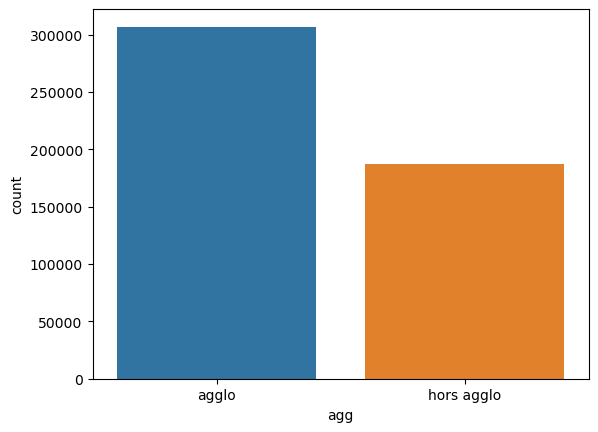

In [21]:
sns.countplot(data=df_merged, x="agg")

<Axes: xlabel='agg', ylabel='proportion'>

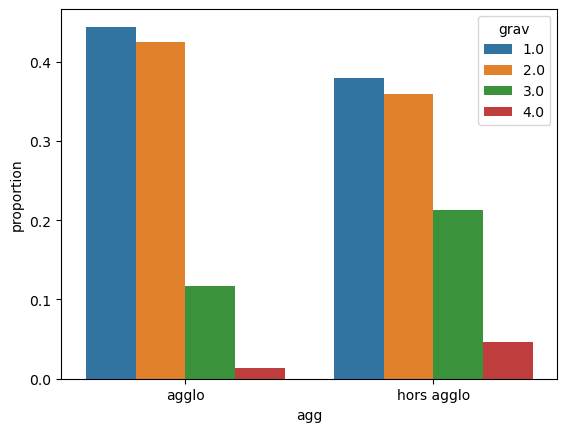

In [22]:
proportions = df_merged.groupby('agg')['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x='agg', y='proportion', hue='grav', data=proportions)

### `place` [-]

On utilisera plutôt la variable `catu`, car finalement les effectifs pour les différentes places sont très faibles.

<Axes: xlabel='place', ylabel='count'>

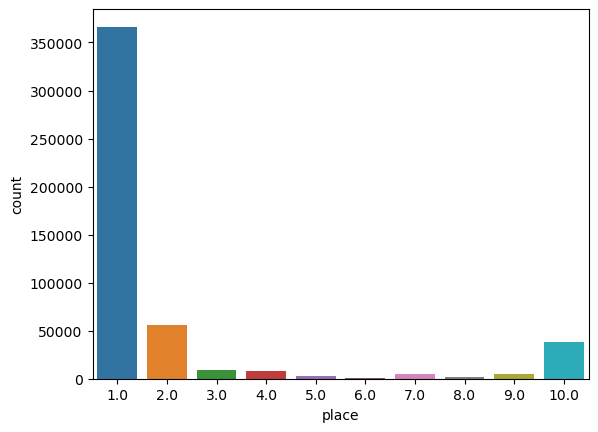

In [23]:
sns.countplot(data=df_merged, x="place")

<Axes: xlabel='place', ylabel='proportion'>

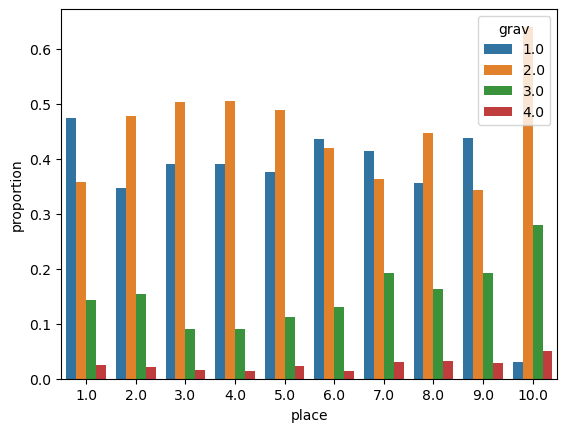

In [24]:
var = "place"
proportions = df_merged.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions)

### `catu` [+++]

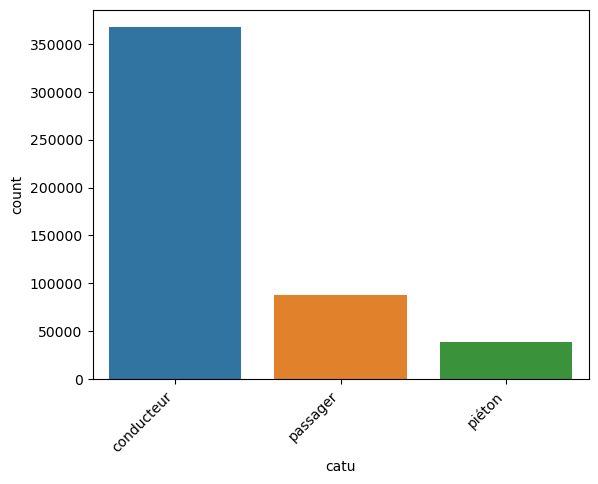

In [25]:
var = "catu"
sns.countplot(data=df_merged, x=var, order=df_merged[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

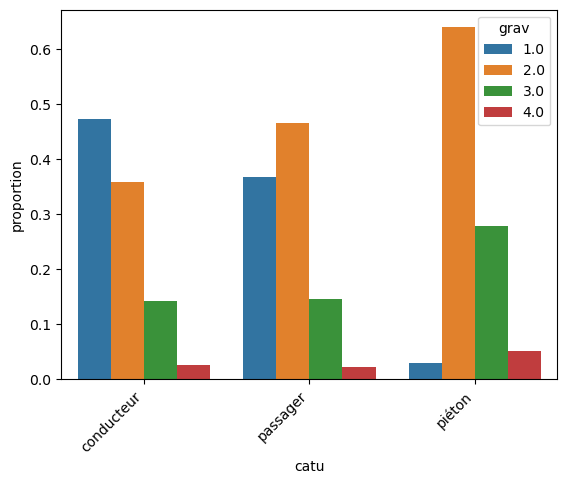

In [26]:
var = "catu"
proportions = df_merged.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions, order=df_merged[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

### `sexe` [++]

<Axes: xlabel='sexe', ylabel='count'>

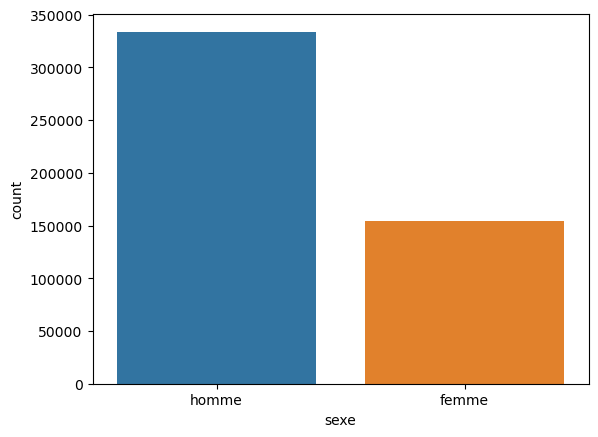

In [27]:
sns.countplot(data=df_merged, x="sexe")

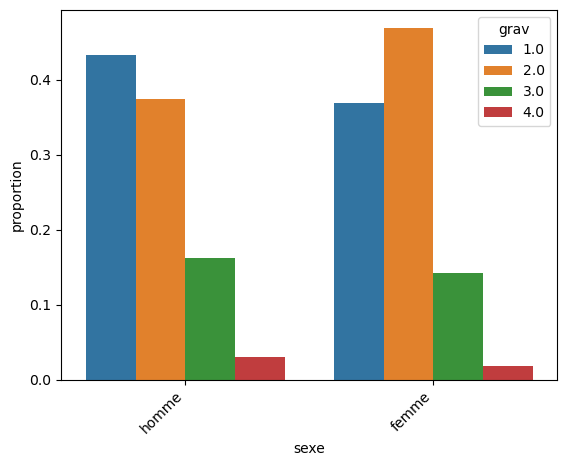

In [28]:
var = "sexe"
proportions = df_merged.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions, order=df_merged[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

### `an_nais` [+] (année de naissance)

<Axes: xlabel='an_nais', ylabel='Density'>

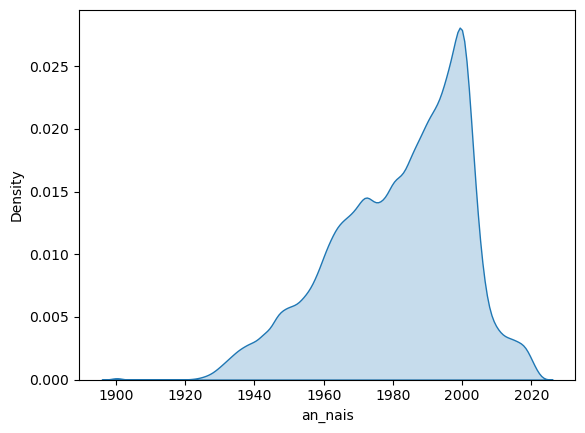

In [29]:
var = "an_nais"
sns.kdeplot(df_merged[var], fill=True)

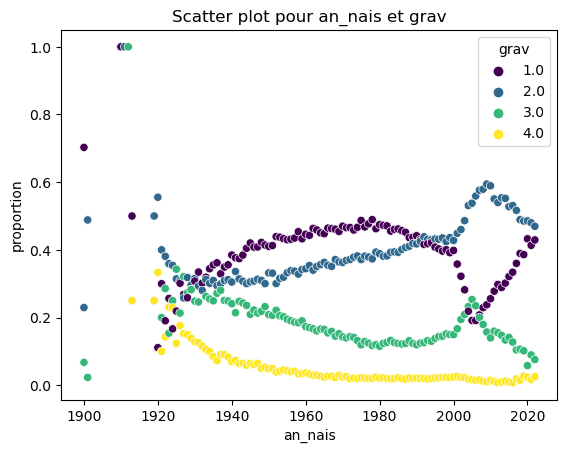

In [30]:
var = "an_nais"
proportions = df_merged.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.scatterplot(data=proportions, x=var, y='proportion', hue='grav', palette='viridis')
plt.title('Scatter plot pour an_nais et grav')
plt.show()

In [31]:
df_merged = df_merged[df_merged["an_nais"] >= 1930]

In [32]:
df_merged["ind_avant_1960"] = df_merged["an_nais"] < 1960
df_merged["ind_2002_2012"] = (df_merged["an_nais"] >= 2002) & (df_merged["an_nais"] <= 2012)

### `heure` [+, 2]

In [33]:
df_merged["heure"].value_counts()

18:00:00    6739
17:00:00    5895
17:30:00    5601
18:30:00    5537
19:00:00    5202
            ... 
04:41:00       3
04:24:00       3
03:36:00       3
03:59:00       2
03:31:00       2
Name: heure, Length: 1438, dtype: int64

In [34]:
df_merged["hrmn"]

0         16:15
1         16:15
2         08:34
3         08:34
4         17:15
          ...  
494177    07:50
494178    02:41
494179    15:20
494180    20:50
494181    20:50
Name: hrmn, Length: 486837, dtype: object

In [35]:
df_merged["heure"].apply(lambda x: x.hour)

0         16
1         16
2          8
3          8
4         17
          ..
494177     7
494178     2
494179    15
494180    20
494181    20
Name: heure, Length: 486837, dtype: int64

<Axes: xlabel='h', ylabel='Density'>

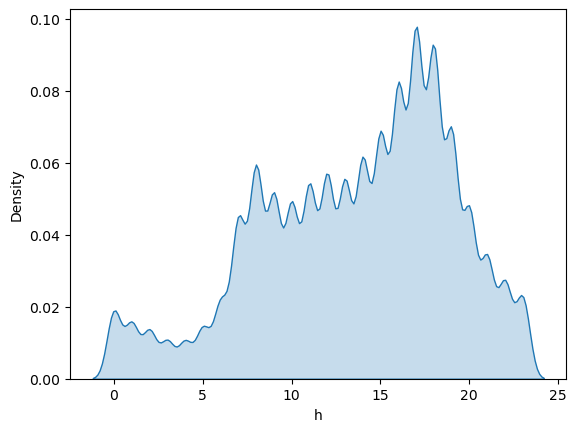

In [36]:
# df_merged["sec"] = df_merged["heure"].apply(lambda x: x.hour * 3600 + x.minute * 60 + x.second)
df_merged["h"] = df_merged["heure"]. apply(lambda x: x.hour)

sns.kdeplot(df_merged["h"], fill=True)

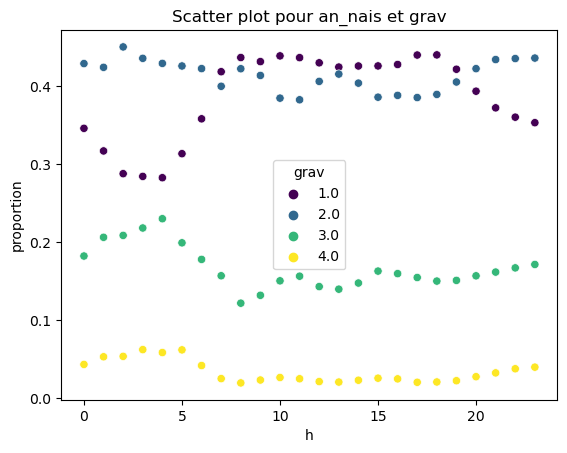

In [37]:
var = "h"
proportions = df_merged.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.scatterplot(data=proportions, x=var, y='proportion', hue='grav', palette='viridis')
plt.title('Scatter plot pour an_nais et grav')
plt.show()

In [38]:
df_merged["heure_2"] = np.where(df_merged["h"] < 7, 0,
                                np.where(df_merged["h"] >= 20, 1, 2))

### `nbv` [+, 2]

<Axes: xlabel='nbv', ylabel='count'>

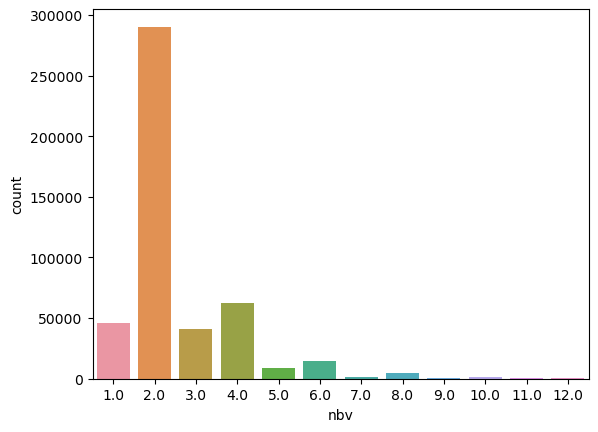

In [39]:
sns.countplot(data=df_merged, x="nbv")

<Axes: xlabel='nbv', ylabel='proportion'>

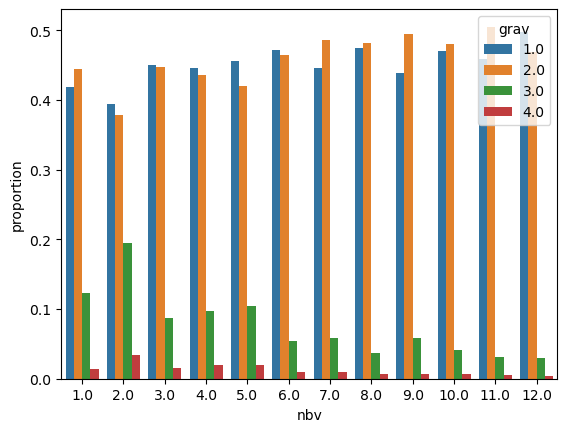

In [40]:
var = "nbv"
proportions = df_merged.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions)

In [41]:
df_merged["nbv_2"] = np.where(df_merged["nbv"].isin([2]), 0,
                              np.where(df_merged["nbv"].isin([1, 3, 4, 5]), 1, 2))

### `trajet` [+]

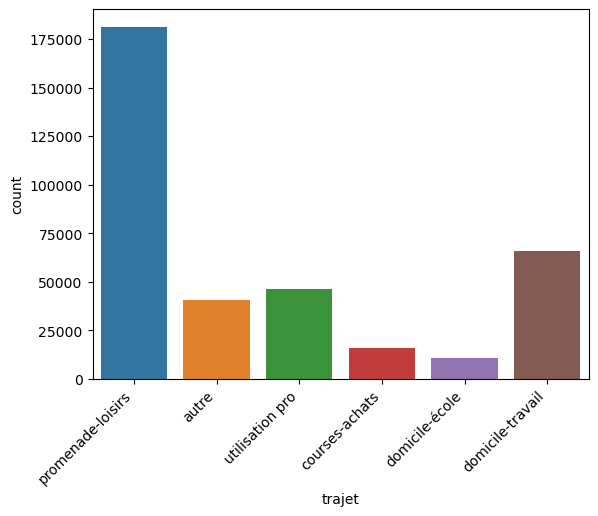

In [42]:
sns.countplot(data=df_merged, x="trajet")
plt.xticks(rotation=45, ha='right')
plt.show()

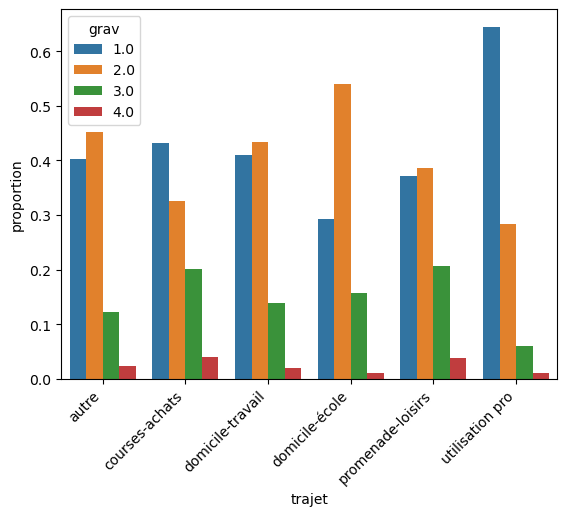

In [43]:
var = "trajet"
proportions = df_merged.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions)
plt.xticks(rotation=45, ha='right')
plt.show()

### `lum` [+, 2]

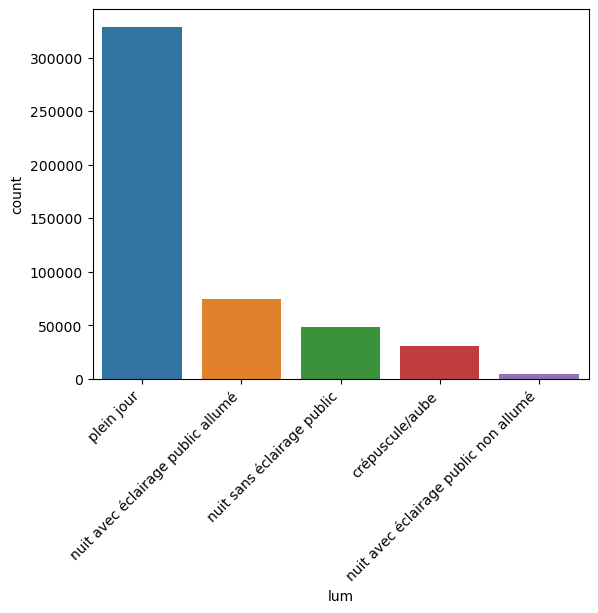

In [44]:
var = "lum"
sns.countplot(data=df_merged, x=var, order=df_merged[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

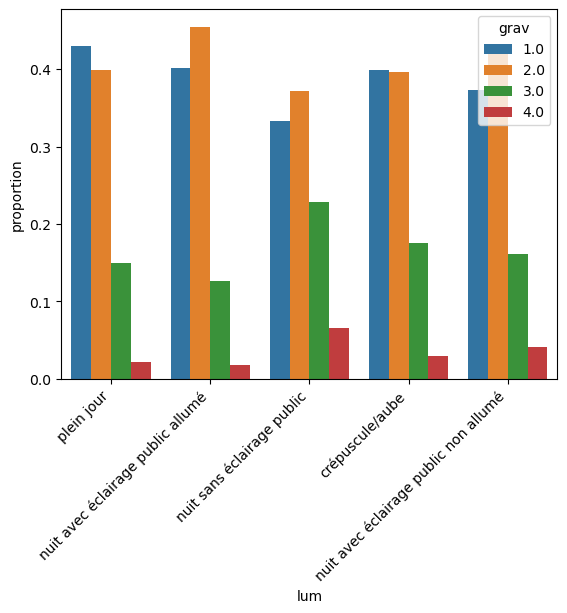

In [45]:
var = "lum"
proportions = df_merged.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions, order=df_merged[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

In [46]:
df_merged["lum_2"] = np.where(df_merged["lum"].isin(["plein jour", "nuit avec éclairage public allumé"]), 1, 0)

### `surf` [-] (surface)

Il n'y a que 2 modalités aux effectifs importants, et leur profil de gravité est très similaire...

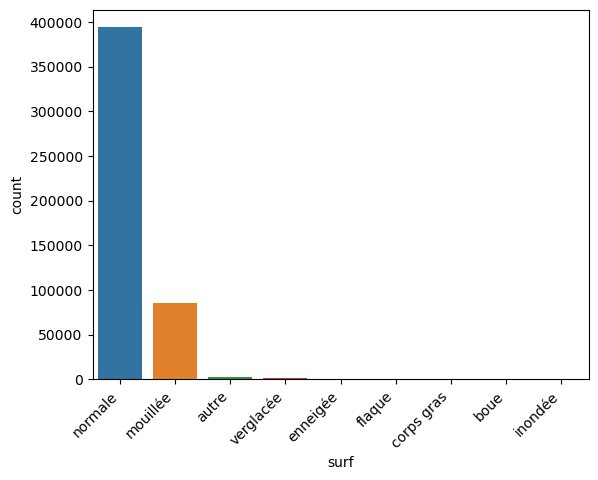

In [47]:
var = "surf"
sns.countplot(data=df_merged, x=var, order=df_merged[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

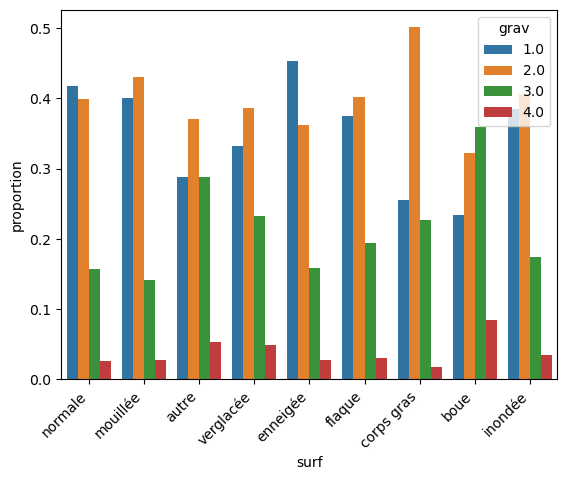

In [48]:
var = "surf"
proportions = df_merged.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions, order=df_merged[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

### `atm` [-] (conditions atmosphériques)

Les modalités dont les effectifs sont significatifs ont des profils de gravité trop similaires.

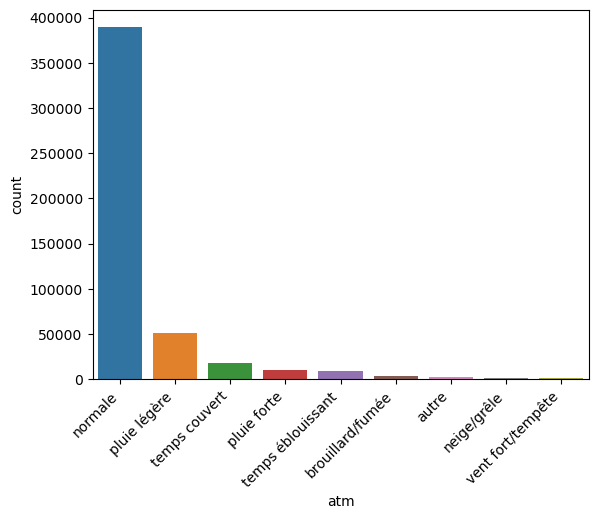

In [49]:
var = "atm"
sns.countplot(data=df_merged, x=var, order=df_merged[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

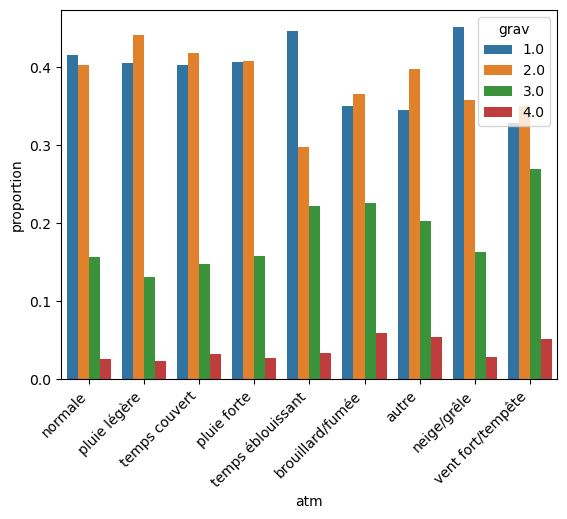

In [50]:
var = "atm"
proportions = df_merged.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions, order=df_merged[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

### `int` [-] (intersection)

Les modalités dont les effectifs sont significatifs ont des profils de gravité trop similaires.

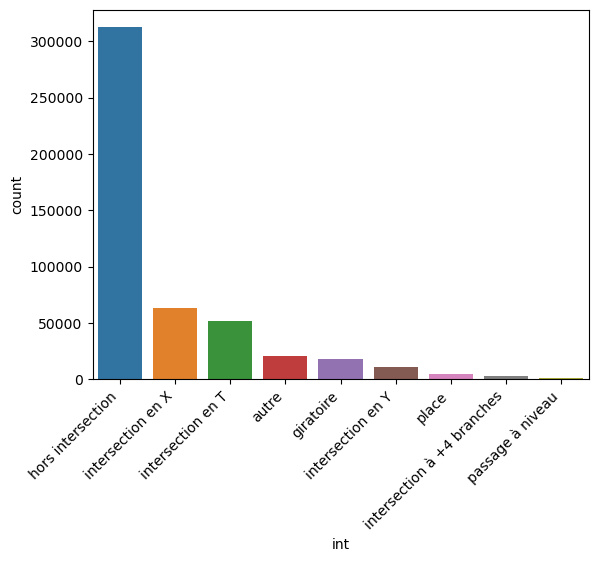

In [51]:
var = "int"
sns.countplot(data=df_merged, x=var, order=df_merged[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

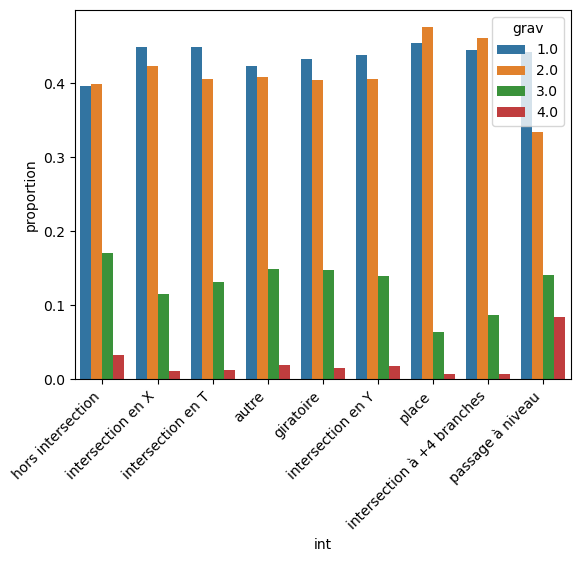

In [52]:
var = "int"
proportions = df_merged.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions, order=df_merged[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

### `col` [+, 2] (collision)

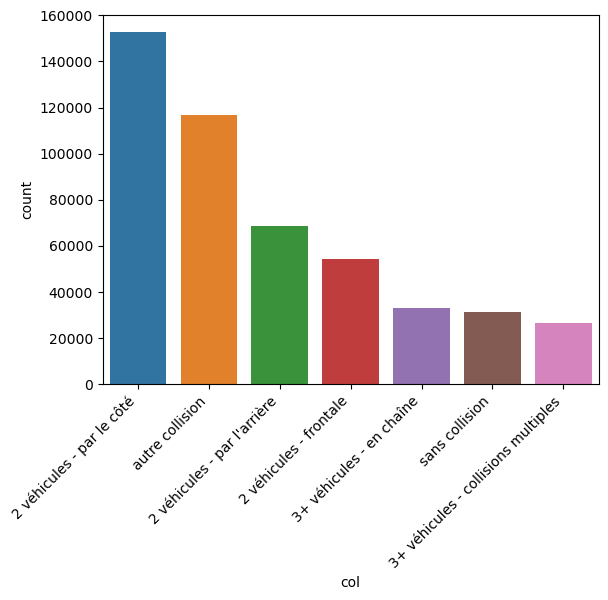

In [53]:
var = "col"
sns.countplot(data=df_merged, x=var, order=df_merged[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

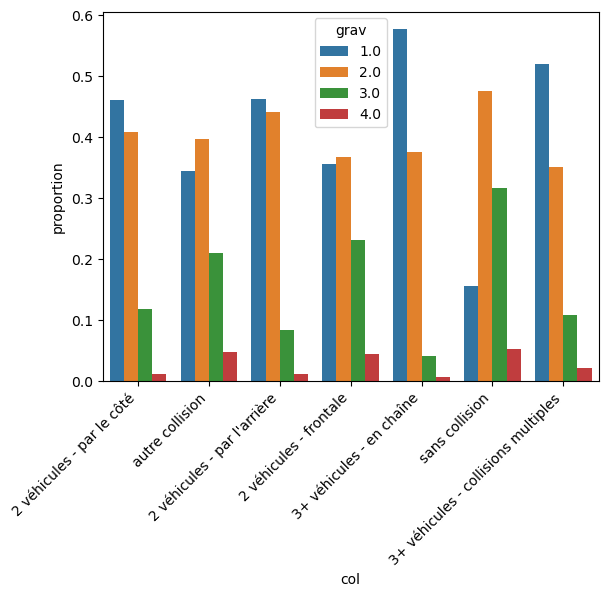

In [54]:
var = "col"
proportions = df_merged.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions, order=df_merged[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

In [55]:
df_merged["col_2"] = np.where(df_merged["col"].isin(["autre collision", "2 véhicules - frontale", "sans collision"]), 1, 0)

### `catr` [+, 2] (catégorie route)

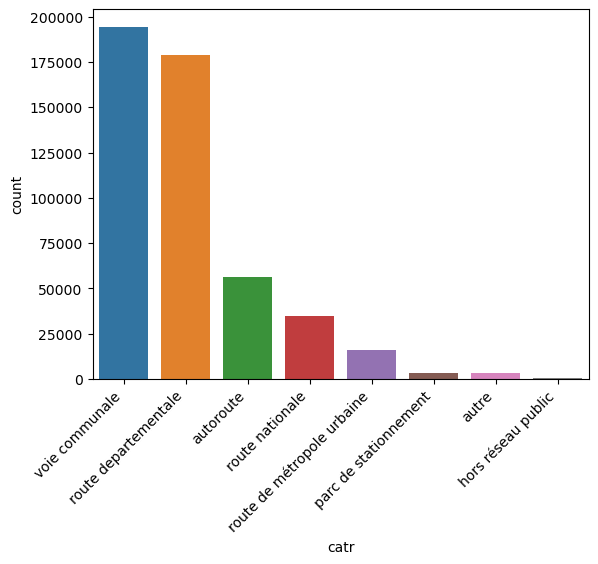

In [56]:
var = "catr"
sns.countplot(data=df_merged, x=var, order=df_merged[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

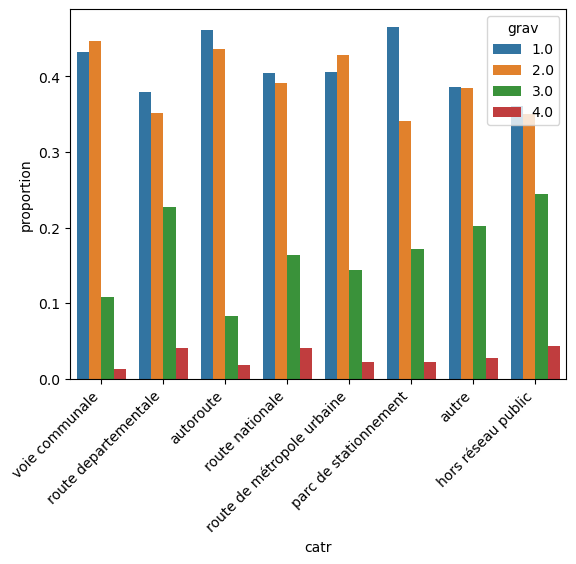

In [57]:
var = "catr"
proportions = df_merged.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions, order=df_merged[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

In [58]:
df_merged["catr_2"] = np.where(df_merged["catr"].isin(["route départementale", "hors réseau public"]), 0,
                               np.where(df_merged["catr"].isin(["route nationale", "route de métropole urbaine",
                                                               "parc de stationnement", "autre"]), 1, 2))

### `circ` [++] (régime de circulation)

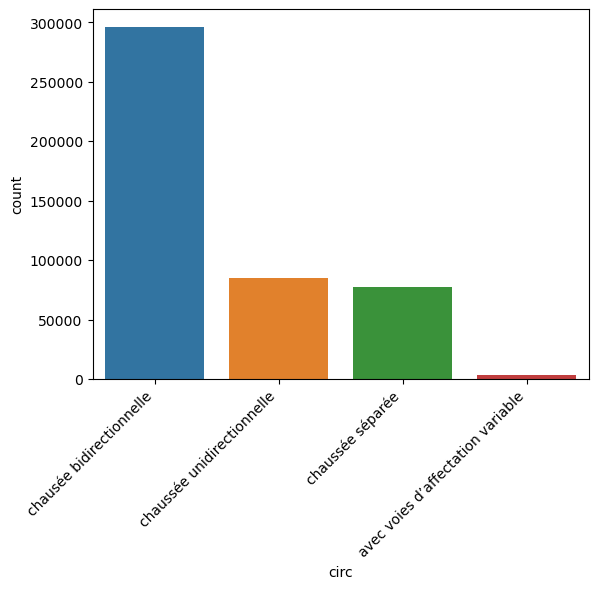

In [59]:
var = "circ"
sns.countplot(data=df_merged, x=var, order=df_merged[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

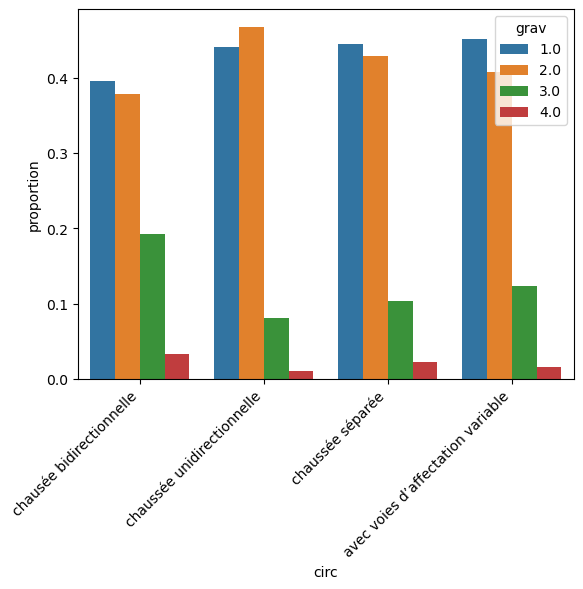

In [60]:
var = "circ"
proportions = df_merged.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions, order=df_merged[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

### `vosp` [-] (voie réservée)

Trop de `NaN` et profils de gravités trop similaires.

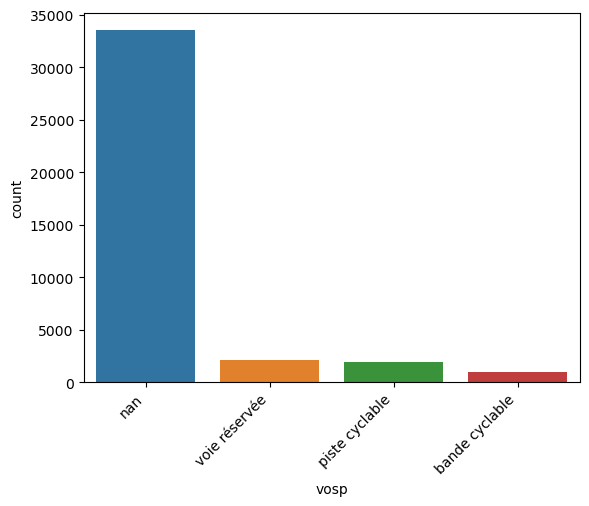

In [61]:
var = "vosp"
df_fill_na = df_pieton.copy()
df_fill_na[var].fillna("nan", inplace=True)
sns.countplot(data=df_fill_na, x=var, order=df_fill_na[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

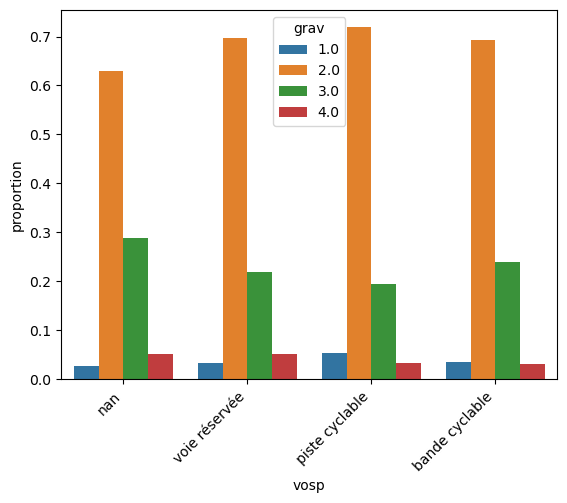

In [62]:
var = "vosp"
proportions = df_fill_na.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions, order=df_fill_na[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

### `prof` [-] (déclivité de la route)

Les modalités ont des profils de gravité trop similaires.

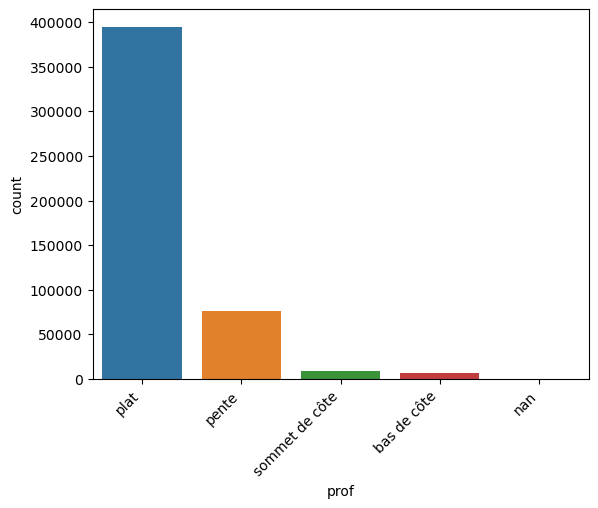

plat              394513
pente              76698
sommet de côte      8462
bas de côte         7086
nan                   78
Name: prof, dtype: int64

In [63]:
var = "prof"
df_fill_na = df_merged.copy()
df_fill_na[var].fillna("nan", inplace=True)
sns.countplot(data=df_fill_na, x=var, order=df_fill_na[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()
df_fill_na[var].value_counts()

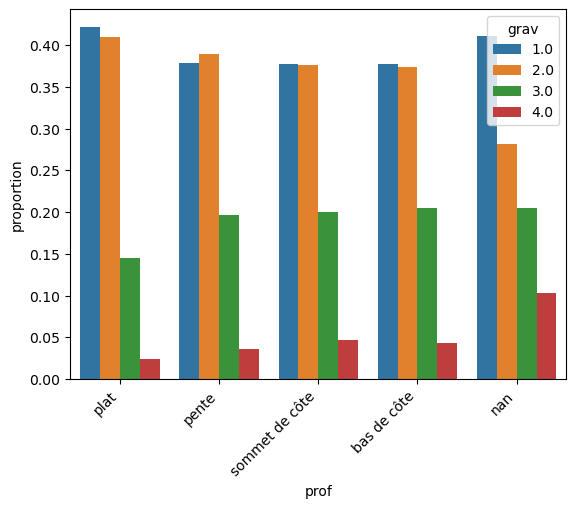

In [64]:
var = "prof"
proportions = df_fill_na.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions, order=df_fill_na[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

### `plan` [+, 2] (tracé en plan)

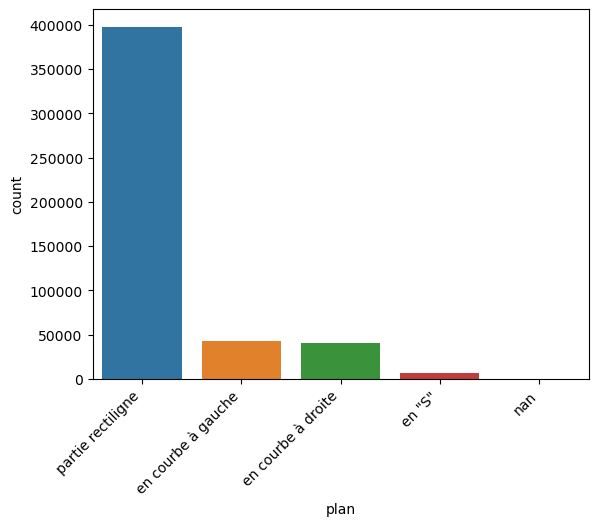

partie rectiligne     397908
en courbe à gauche     42301
en courbe à droite     40459
en "S"                  6109
nan                       60
Name: plan, dtype: int64

In [65]:
var = "plan"
df_fill_na = df_merged.copy()
df_fill_na[var].fillna("nan", inplace=True)
sns.countplot(data=df_fill_na, x=var, order=df_fill_na[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()
df_fill_na[var].value_counts()

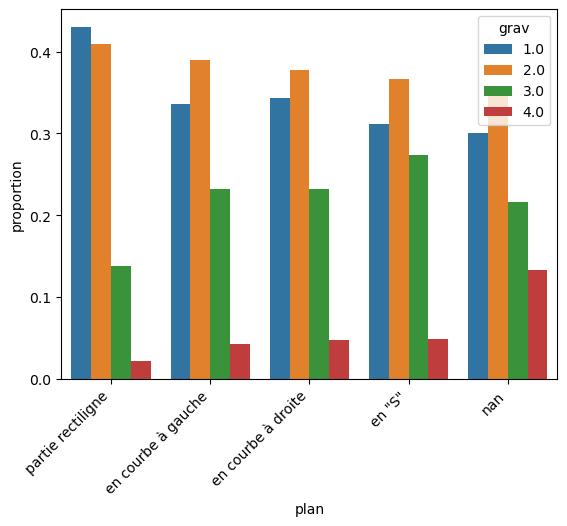

In [66]:
var = "plan"
proportions = df_fill_na.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions, order=df_fill_na[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

In [67]:
df_merged["plan_2"] = np.where(df_merged["plan"].isin(["partie rectiligne"]), 1, 0)

### `infra` [-] (aménagement, infrastructure)

Il y a _a priori_ trop peu de non `NaN` pour en tirer quelque chose d'intéressant, et de toute façon les profils de gravité sont assez similaires.

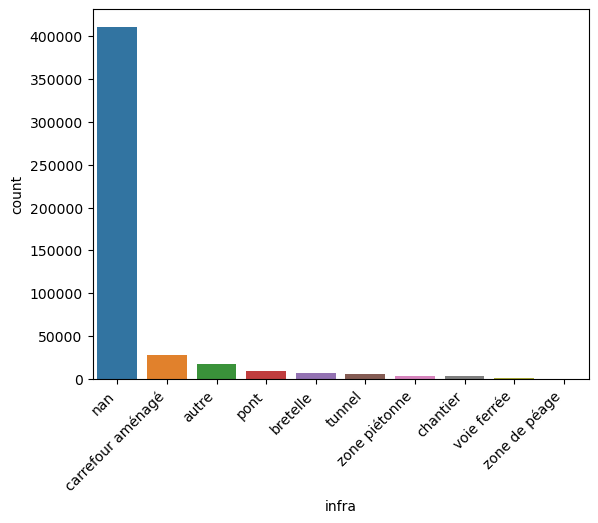

nan                  410499
carrefour aménagé     27761
autre                 16992
pont                   8845
bretelle               6748
tunnel                 6393
zone piétonne          3962
chantier               3739
voie ferrée            1531
zone de péage           367
Name: infra, dtype: int64

In [68]:
var = "infra"
df_fill_na = df_merged.copy()
df_fill_na[var].fillna("nan", inplace=True)
sns.countplot(data=df_fill_na, x=var, order=df_fill_na[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()
df_fill_na[var].value_counts()

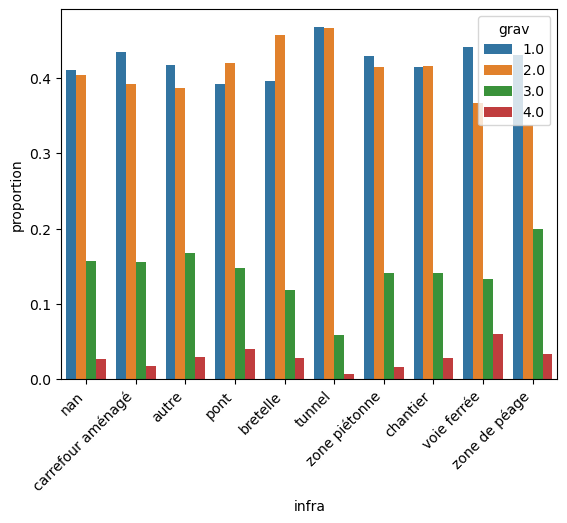

In [69]:
var = "infra"
proportions = df_fill_na.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions, order=df_fill_na[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

### `situ` [+, 2]

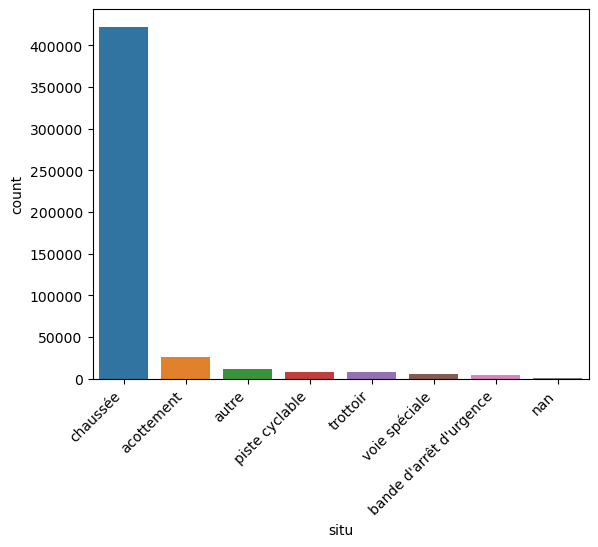

chaussée                   422258
acottement                  26228
autre                       12089
piste cyclable               8582
trottoir                     7585
voie spéciale                5542
bande d'arrêt d'urgence      4280
nan                           273
Name: situ, dtype: int64

In [70]:
var = "situ"
df_fill_na = df_merged.copy()
df_fill_na[var].fillna("nan", inplace=True)
sns.countplot(data=df_fill_na, x=var, order=df_fill_na[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()
df_fill_na[var].value_counts()

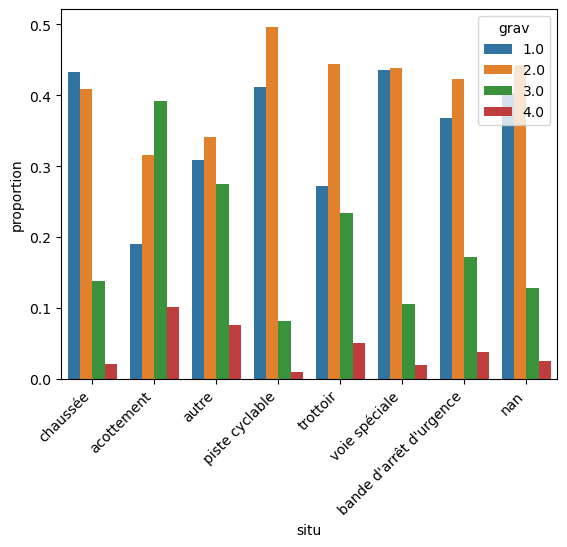

In [71]:
var = "situ"
proportions = df_fill_na.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions, order=df_fill_na[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

In [72]:
df_merged["situ_2"] = np.where(df_merged["situ"].isin(["acottement"]), 0, 
                               np.where(df_merged["situ"].isin(["autre", "trottoir"]), 1, 2))

### `obs` [-] (obstacle fixe heurté)

Pas très intéressant, quasi que des "sans objet" puisque ce sont essentiellement des obstacles mobiles.

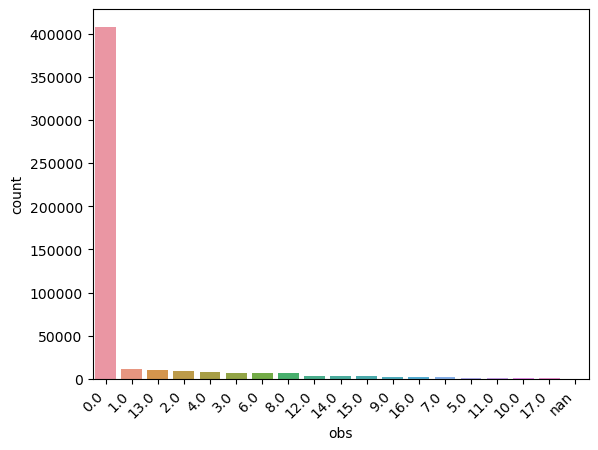

0.0     408029
1.0      11516
13.0     10077
2.0       8767
4.0       7491
3.0       7403
6.0       6573
8.0       6491
12.0      3809
14.0      3622
15.0      3301
9.0       2577
16.0      2223
7.0       1663
5.0        955
11.0       921
10.0       639
17.0       627
nan        153
Name: obs, dtype: int64

In [73]:
var = "obs"
df_fill_na = df_merged.copy()
df_fill_na[var].fillna("nan", inplace=True)
sns.countplot(data=df_fill_na, x=var, order=df_fill_na[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()
df_fill_na[var].value_counts()

### `obsm` [+, 2] (type d'obstacle heurté)

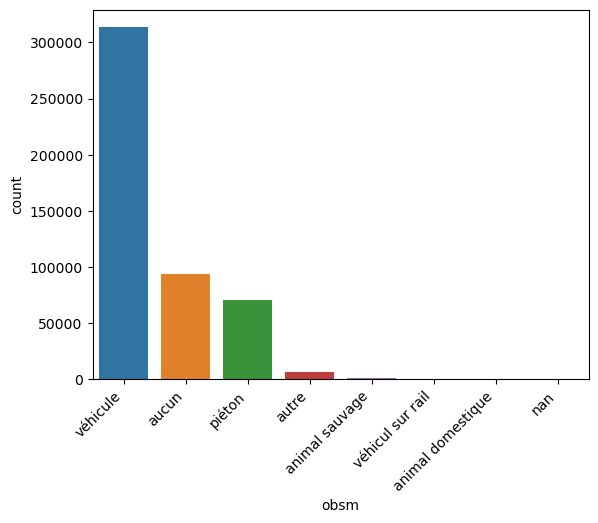

véhicule             313447
aucun                 94173
piéton                70617
autre                  6249
animal sauvage         1278
véhicul sur rail        473
animal domestique       377
nan                     223
Name: obsm, dtype: int64

In [74]:
var = "obsm"
df_fill_na = df_merged.copy()
df_fill_na[var].fillna("nan", inplace=True)
sns.countplot(data=df_fill_na, x=var, order=df_fill_na[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()
df_fill_na[var].value_counts()

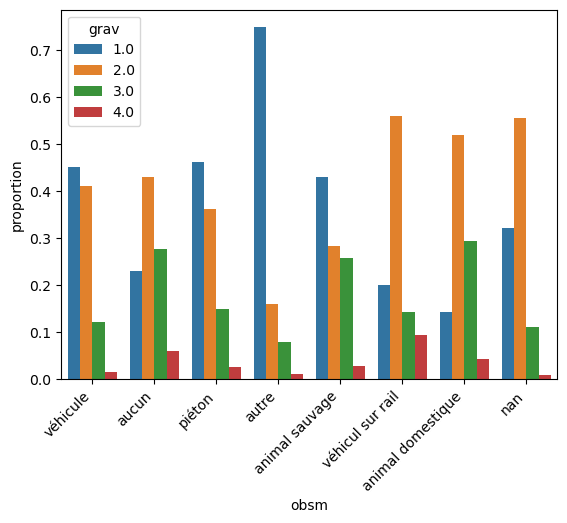

In [75]:
var = "obsm"
proportions = df_fill_na.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions, order=df_fill_na[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

In [76]:
df_merged["obsm_2"] = np.where(df_merged["obsm"].isin(["aucun"]), 0, 
                               np.where(df_merged["obsm"].isin(["autre"]), 1, 2))

### `choc` [+, 2 à venir]

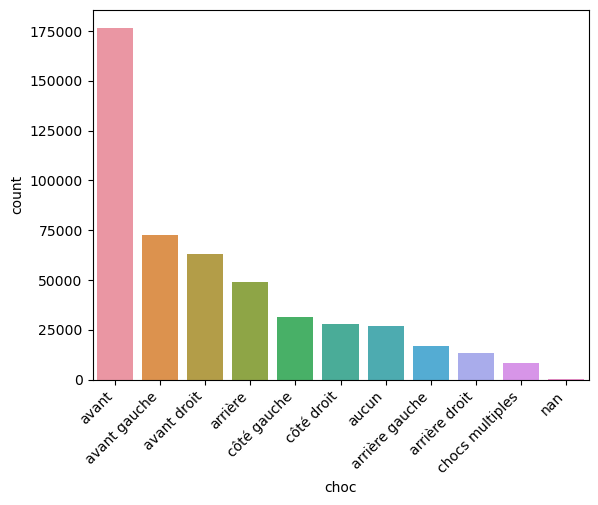

avant              176763
avant gauche        72826
avant droit         63136
arrière             48960
côté gauche         31623
côté droit          27892
aucun               26847
arrière gauche      16935
arrière droit       13517
chocs multiples      8146
nan                   192
Name: choc, dtype: int64

In [77]:
var = "choc"
df_fill_na = df_merged.copy()
df_fill_na[var].fillna("nan", inplace=True)
sns.countplot(data=df_fill_na, x=var, order=df_fill_na[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()
df_fill_na[var].value_counts()

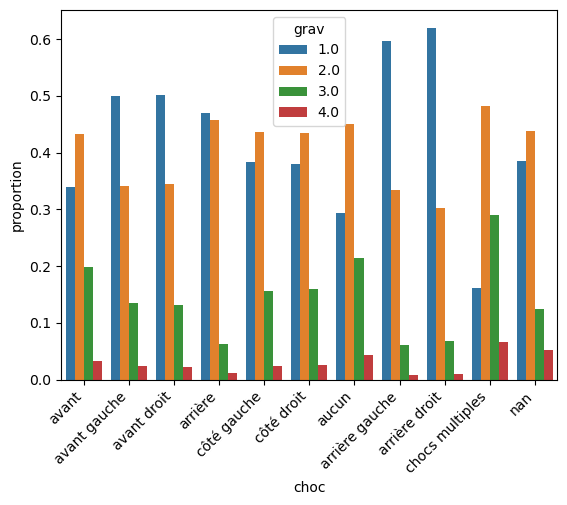

In [78]:
var = "choc"
proportions = df_fill_na.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions, order=df_fill_na[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

### `manv` [+, réfléchir]

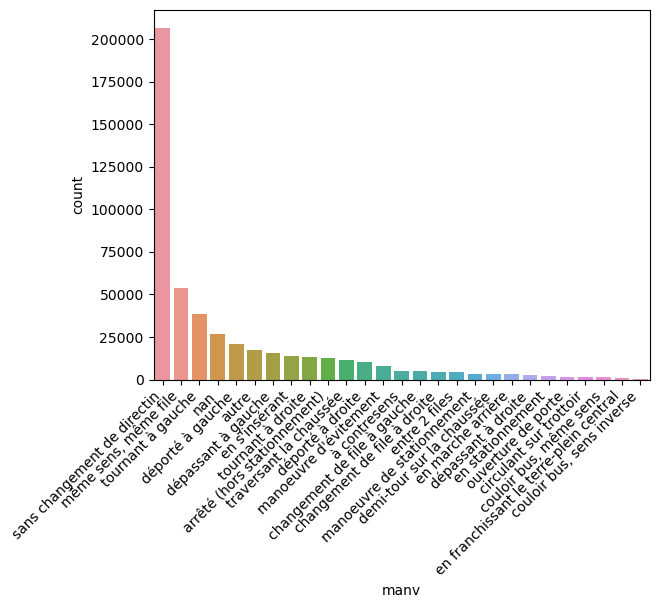

sans changement de directin               206884
même sens, même file                       53753
tournant à gauche                          38275
nan                                        26981
déporté à gauche                           21001
autre                                      17200
dépassant à gauche                         15712
en s'insérant                              13909
tournant à droite                          13104
arrêté (hors stationnement)                12429
traversant la chaussée                     11706
déporté à droite                           10551
manoeuvre d'évitement                       7859
à contresens                                4981
changement de file à gauche                 4971
changement de file à droite                 4414
entre 2 files                               4384
manoeuvre de stationnement                  3165
demi-tour sur la chaussée                   3063
en marche arrière                           3024
dépassant à droite  

In [79]:
var = "manv"
df_fill_na = df_merged.copy()
df_fill_na[var].fillna("nan", inplace=True)
sns.countplot(data=df_fill_na, x=var, order=df_fill_na[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()
df_fill_na[var].value_counts()

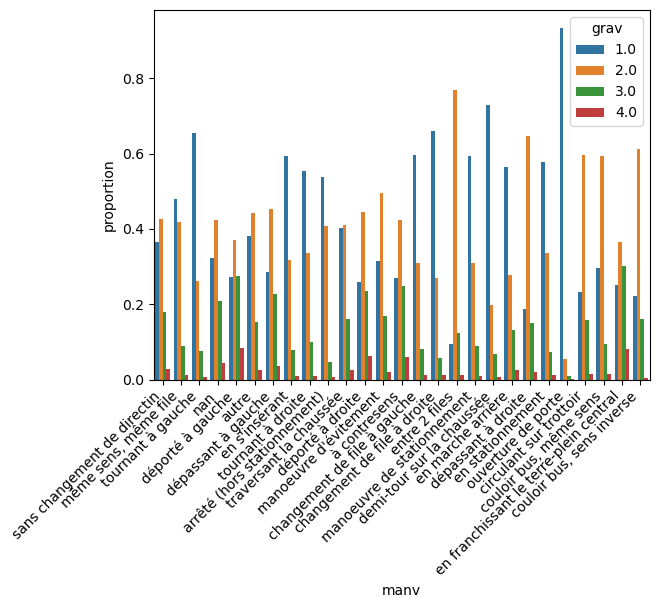

In [80]:
var = "manv"
proportions = df_fill_na.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions, order=df_fill_na[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

### `motor` [+, réfléchir] (motorisation du véhicule)

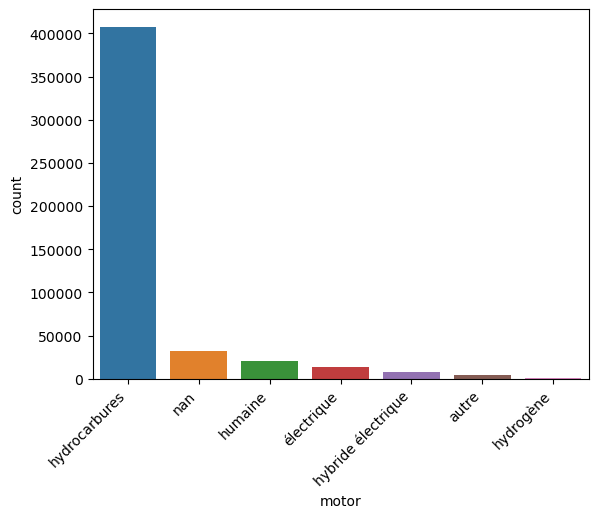

hydrocarbures         407859
nan                    32626
humaine                20717
électrique             13147
hybride électrique      7886
autre                   4304
hydrogène                298
Name: motor, dtype: int64

In [81]:
var = "motor"
df_fill_na = df_merged.copy()
df_fill_na[var].fillna("nan", inplace=True)
sns.countplot(data=df_fill_na, x=var, order=df_fill_na[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()
df_fill_na[var].value_counts()

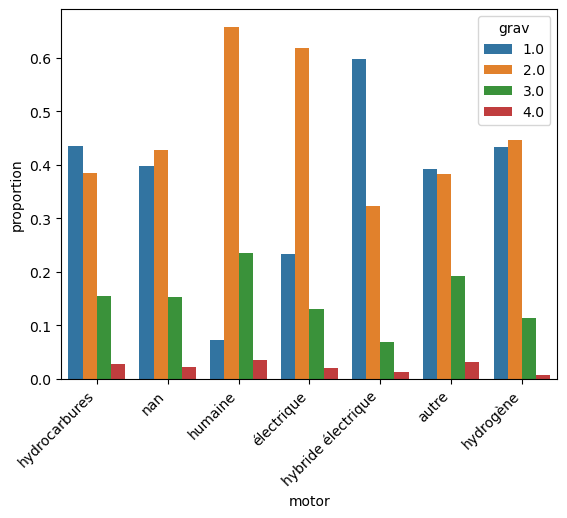

In [82]:
var = "motor"
proportions = df_fill_na.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions, order=df_fill_na[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

### `locp` [-] (localisation du piéton)

Les modalités dont les effectifs sont significatifs ont des profils de gravité trop similaires.

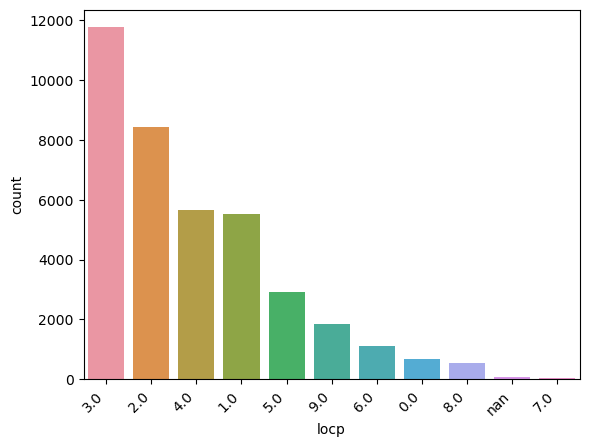

3.0    11762
2.0     8424
4.0     5671
1.0     5509
5.0     2924
9.0     1837
6.0     1108
0.0      688
8.0      544
nan       82
7.0       42
Name: locp, dtype: int64

In [83]:
var = "locp"
df_fill_na = df_pieton.copy()
df_fill_na[var].fillna("nan", inplace=True)
sns.countplot(data=df_fill_na, x=var, order=df_fill_na[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()
df_fill_na[var].value_counts()

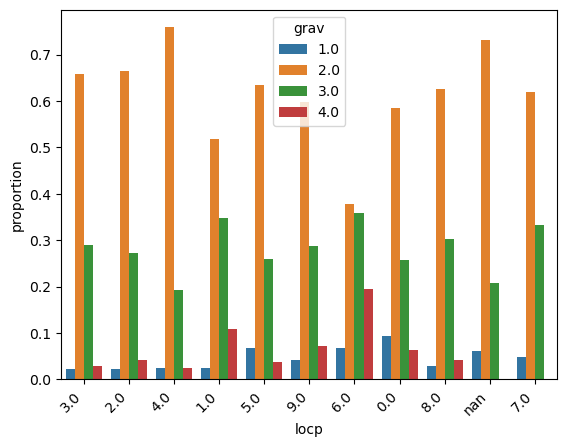

In [84]:
var = "locp"
proportions = df_fill_na.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions, order=df_fill_na[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

### `actp` [-] (action du piéton)

La variable est trop peu variée pour être intéressante à exploiter.

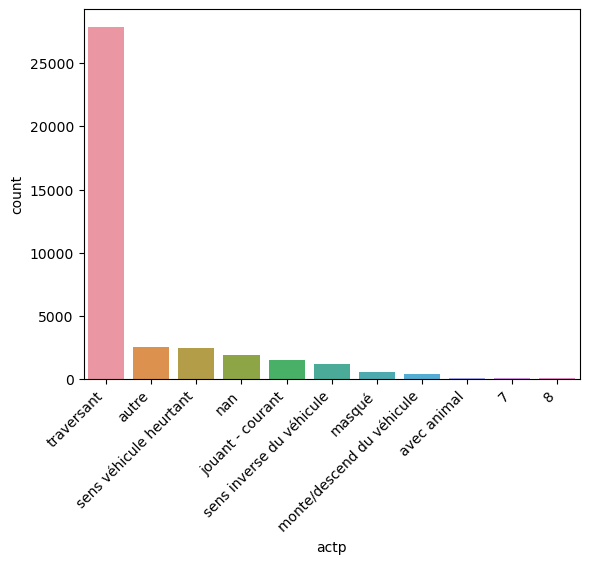

traversant                   27870
autre                         2523
sens véhicule heurtant        2440
nan                           1903
jouant - courant              1531
sens inverse du véhicule      1156
masqué                         529
monte/descend du véhicule      421
avec animal                    106
7                               60
8                               52
Name: actp, dtype: int64

In [85]:
var = "actp"
df_fill_na = df_pieton.copy()
df_fill_na[var].fillna("nan", inplace=True)
sns.countplot(data=df_fill_na, x=var, order=df_fill_na[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()
df_fill_na[var].value_counts()

### `etatp` [-]

Profils de gravité trop similaires.

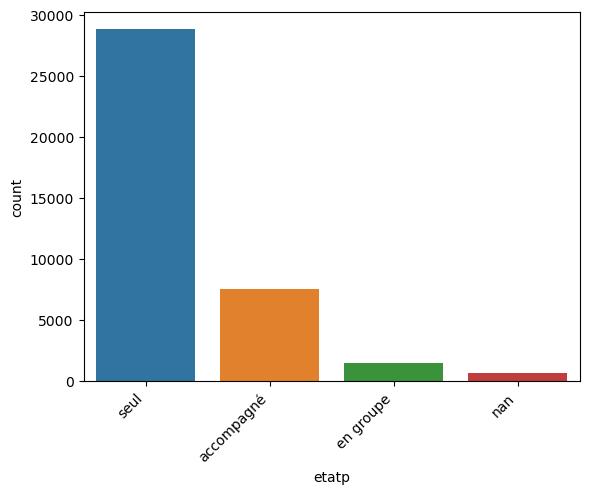

seul          28815
accompagné     7558
en groupe      1509
nan             709
Name: etatp, dtype: int64

In [86]:
var = "etatp"
df_fill_na = df_pieton.copy()
df_fill_na[var].fillna("nan", inplace=True)
sns.countplot(data=df_fill_na, x=var, order=df_fill_na[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()
df_fill_na[var].value_counts()

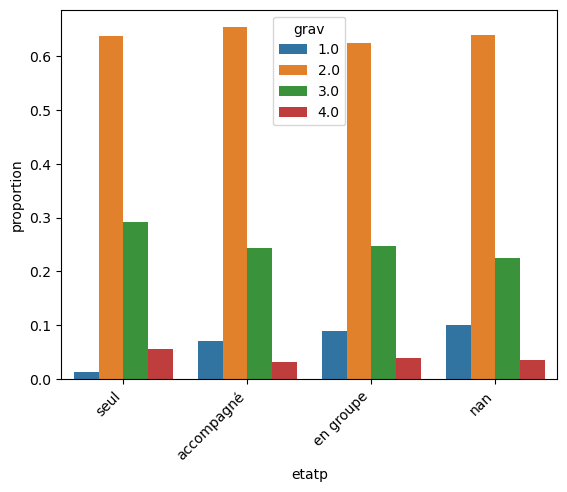

In [87]:
var = "etatp"
proportions = df_fill_na.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions, order=df_fill_na[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

## Equipements

### `ceinture` [+++]

<Axes: xlabel='ceinture', ylabel='count'>

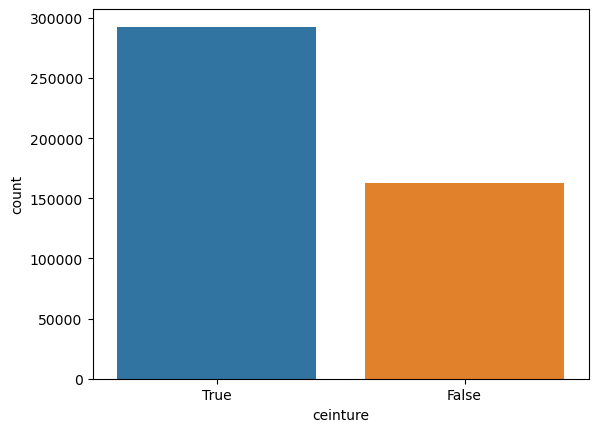

In [88]:
var = "ceinture"
sns.countplot(data=df_non_pieton, x=var, order=df_non_pieton[var].value_counts().index)

<Axes: xlabel='ceinture', ylabel='proportion'>

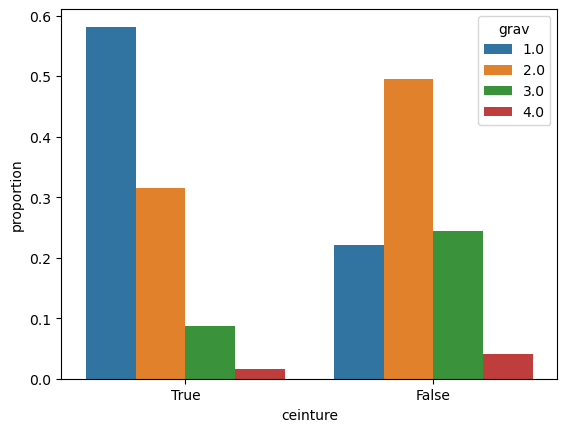

In [89]:
var = "ceinture"
proportions = df_non_pieton.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions, order=df_non_pieton[var].value_counts().index)

# Premiers modèles

In [90]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import statsmodels.api as sm

### MCO


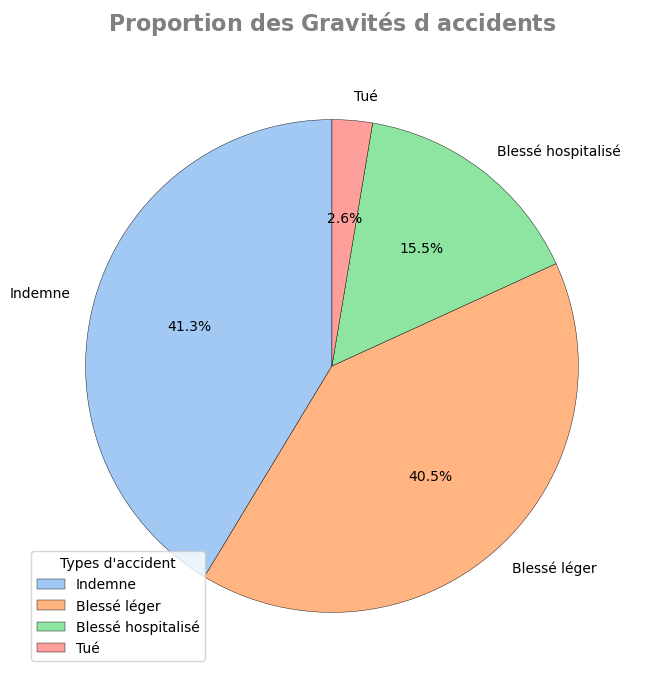

In [91]:
accident_counts = df_merged['grav'].value_counts()
labels_pie_chart = {1: 'Indemne', 2: 'Blessé léger', 3: 'Blessé hospitalisé', 4: 'Tué'}
accident_counts.index = accident_counts.index.map(labels_pie_chart)
colors = sns.color_palette('pastel')  
plt.figure(figsize=(8, 8))
plt.pie(accident_counts, labels=accident_counts.index, autopct='%1.1f%%', startangle=90, colors=colors, wedgeprops=dict(width=1, edgecolor='black', linewidth=0.3)) # dict(width=1)
plt.title(r'$\bf{ Proportion\ des\ Gravités\ d\ accidents}$', fontsize=16, loc='center', pad=20, color='grey')
plt.legend(title='Types d\'accident', loc='lower left', bbox_to_anchor=(0.0005, 0.01))
plt.show() ##  ça a rien a foutre là mais c'est là quand même 

In [96]:
numeric_features = ["an_nais", "h", "vma"]
categorical_features = ["agg", "catu", "sexe", "nbv_2", "trajet", "lum_2", "col_2", 
                        "catr_2", "circ", "plan_2", "situ_2", "obsm_2", "ceinture","obsm"]


df_elem1 = df_merged[["grav"] + numeric_features + categorical_features]

df_elem1.dropna(inplace=True)

df_elem1 ####

C:\Users\User\AppData\Local\Temp\ipykernel_1376\2394482453.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_elem1.dropna(inplace=True)


,grav,an_nais,h,vma,agg,catu,sexe,nbv_2,trajet,lum_2,col_2,catr_2,circ,plan_2,situ_2,obsm_2,ceinture,obsm
0,3.0,2008.0,16,50.0,agglo,conducteur,homme,0,promenade-loisirs,1,0,2,chausée bidirectionnelle,1,2,2,False,véhicule
1,1.0,1948.0,16,50.0,agglo,conducteur,homme,0,promenade-loisirs,1,0,2,chausée bidirectionnelle,1,2,2,True,véhicule
2,2.0,1988.0,8,50.0,agglo,conducteur,homme,0,autre,1,0,2,chausée bidirectionnelle,1,2,2,True,véhicule
3,1.0,1970.0,8,50.0,agglo,conducteur,homme,0,utilisation pro,1,0,2,chausée bidirectionnelle,1,2,2,True,véhicule
7,2.0,1967.0,18,30.0,agglo,piéton,femme,1,promenade-loisirs,1,1,2,chaussée unidirectionnelle,1,2,2,False,piéton
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494174,2.0,1968.0,9,130.0,hors agglo,passager,homme,1,promenade-loisirs,1,0,2,chaussée unidirectionnelle,1,2,2,True,véhicule
494175,1.0,1972.0,7,90.0,hors agglo,conducteur,femme,0,domicile-travail,1,0,2,chaussée unidirectionnelle,1,2,2,True,véhicule
494176,2.0,1964.0,7,90.0,hors agglo,conducteur,homme,0,domicile-travail,1,0,2,chaussée unidirectionnelle,1,2,2,True,véhicule
494177,2.0,1988.0,7,90.0,hors agglo,conducteur,femme,0,domicile-travail,1,0,2,chaussée unidirectionnelle,1,2,2,True,véhicule


In [93]:
df_elem1["obsm_2"].value_counts()

2    264282
0     69062
1      4174
Name: obsm_2, dtype: int64

Encodage pour régression linéaire: il s'agit d'avoir des variables binaires, et passer les D.T time en variable numériques calssiques

In [97]:
df_elem1_bin=pd.get_dummies(df_elem1,columns=["catu","sexe","agg","circ","trajet","obsm_2","obsm"],drop_first=True )# on drop pour éviter la colinéarité parfaite
df_elem1_bin["an_nais"]=df_elem1_bin["an_nais"].astype(int)   # Statmodels ne prends les format DT.time  
df_elem1_bin['ceinture'] = df_elem1_bin['ceinture'].astype(int)  # ni les booléens 
df_elem1_bin.dropna(inplace=True)
df_elem1_bin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 337449 entries, 0 to 494178
Data columns (total 31 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   grav                             337449 non-null  float64
 1   an_nais                          337449 non-null  int32  
 2   h                                337449 non-null  int64  
 3   vma                              337449 non-null  float64
 4   nbv_2                            337449 non-null  int32  
 5   lum_2                            337449 non-null  int32  
 6   col_2                            337449 non-null  int32  
 7   catr_2                           337449 non-null  int32  
 8   plan_2                           337449 non-null  int32  
 9   situ_2                           337449 non-null  int32  
 10  ceinture                         337449 non-null  int32  
 11  catu_passager                    337449 non-null  uint8  
 12  ca

In [98]:
df_elem1_bin

,grav,an_nais,h,vma,nbv_2,lum_2,col_2,catr_2,plan_2,situ_2,...,trajet_promenade-loisirs,trajet_utilisation pro,obsm_2_1,obsm_2_2,obsm_animal sauvage,obsm_aucun,obsm_autre,obsm_piéton,obsm_véhicul sur rail,obsm_véhicule
0,3.0,2008,16,50.0,0,1,0,2,1,2,...,1,0,0,1,0,0,0,0,0,1
1,1.0,1948,16,50.0,0,1,0,2,1,2,...,1,0,0,1,0,0,0,0,0,1
2,2.0,1988,8,50.0,0,1,0,2,1,2,...,0,0,0,1,0,0,0,0,0,1
3,1.0,1970,8,50.0,0,1,0,2,1,2,...,0,1,0,1,0,0,0,0,0,1
7,2.0,1967,18,30.0,1,1,1,2,1,2,...,1,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494174,2.0,1968,9,130.0,1,1,0,2,1,2,...,1,0,0,1,0,0,0,0,0,1
494175,1.0,1972,7,90.0,0,1,0,2,1,2,...,0,0,0,1,0,0,0,0,0,1
494176,2.0,1964,7,90.0,0,1,0,2,1,2,...,0,0,0,1,0,0,0,0,0,1
494177,2.0,1988,7,90.0,0,1,0,2,1,2,...,0,0,0,1,0,0,0,0,0,1


In [99]:
print(df_elem1_bin.dtypes)

grav                               float64
an_nais                              int32
h                                    int64
vma                                float64
nbv_2                                int32
lum_2                                int32
col_2                                int32
catr_2                               int32
plan_2                               int32
situ_2                               int32
ceinture                             int32
catu_passager                        uint8
catu_piéton                          uint8
sexe_homme                           uint8
agg_hors agglo                       uint8
circ_chaussée séparée                uint8
circ_chaussée unidirectionnelle      uint8
circ_chausée bidirectionnelle        uint8
trajet_courses-achats                uint8
trajet_domicile-travail              uint8
trajet_domicile-école                uint8
trajet_promenade-loisirs             uint8
trajet_utilisation pro               uint8
obsm_2_1   

In [100]:
X = df_elem1_bin.drop('grav', axis=1)
y = df_elem1_bin['grav']
X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary2())

                         Results: Ordinary least squares
Model:                   OLS                  Adj. R-squared:         0.326      
Dependent Variable:      grav                 AIC:                    682427.9352
Date:                    2023-12-14 09:09     BIC:                    682739.0811
No. Observations:        337449               Log-Likelihood:         -3.4118e+05
Df Model:                28                   F-statistic:            5839.      
Df Residuals:            337420               Prob (F-statistic):     0.00       
R-squared:               0.326                Scale:                  0.44235    
---------------------------------------------------------------------------------
                                 Coef.  Std.Err.     t     P>|t|   [0.025  0.975]
---------------------------------------------------------------------------------
const                            5.7136   0.0939   60.8385 0.0000  5.5295  5.8977
an_nais                         -0.0028  

### KNeighbors

In [91]:
numeric_features = ["an_nais", "h", "vma"]
categorical_features = ["agg", "catu", "sexe", "nbv_2", "trajet", "lum_2", "col_2", 
                        "catr_2", "circ", "plan_2", "situ_2", "obsm_2", "ceinture"]


df_elem1 = df_merged[["grav"] + numeric_features + categorical_features]

df_elem1.dropna(inplace=True)

df_elem1

c:\Users\nahta\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,grav,an_nais,h,vma,agg,catu,sexe,nbv_2,trajet,lum_2,col_2,catr_2,circ,plan_2,situ_2,obsm_2,ceinture
0,3.0,2008.0,16,50.0,agglo,conducteur,homme,0,promenade-loisirs,1,0,2,chausée bidirectionnelle,1,2,2,False
1,1.0,1948.0,16,50.0,agglo,conducteur,homme,0,promenade-loisirs,1,0,2,chausée bidirectionnelle,1,2,2,True
2,2.0,1988.0,8,50.0,agglo,conducteur,homme,0,autre,1,0,2,chausée bidirectionnelle,1,2,2,True
3,1.0,1970.0,8,50.0,agglo,conducteur,homme,0,utilisation pro,1,0,2,chausée bidirectionnelle,1,2,2,True
7,2.0,1967.0,18,30.0,agglo,piéton,femme,1,promenade-loisirs,1,1,2,chaussée unidirectionnelle,1,2,2,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494174,2.0,1968.0,9,130.0,hors agglo,passager,homme,1,promenade-loisirs,1,0,2,chaussée unidirectionnelle,1,2,2,True
494175,1.0,1972.0,7,90.0,hors agglo,conducteur,femme,0,domicile-travail,1,0,2,chaussée unidirectionnelle,1,2,2,True
494176,2.0,1964.0,7,90.0,hors agglo,conducteur,homme,0,domicile-travail,1,0,2,chaussée unidirectionnelle,1,2,2,True
494177,2.0,1988.0,7,90.0,hors agglo,conducteur,femme,0,domicile-travail,1,0,2,chaussée unidirectionnelle,1,2,2,True


In [93]:
from sklearn.neighbors import KNeighborsClassifier

# Supposons que vous ayez un DataFrame df_elem1 avec les colonnes nécessaires
# Remplacez cela par votre DataFrame réel

# Séparation des features (X) et de la variable cible (y)

X = df_elem1.drop("grav", axis=1)
y = df_elem1["grav"]

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Créer un transformateur pour les variables continues et catégorielles



In [107]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Créer le pipeline SVC avec le préprocesseur
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors=10))
])

# Entraîner le modèle sur les données d'entraînement
model.fit(X_train, y_train)

# Évaluer le modèle sur les données de test
accuracy = model.score(X_test, y_test)
print(f"Accuracy: {accuracy:.2f}")


Accuracy: 0.60


In [94]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier

# Supposons que vous ayez déjà défini numeric_features, categorical_features, X_train, y_train, X_test, y_test

# Définir les transformers
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Définir le preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Créer le pipeline SVC avec le préprocesseur
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors=10))
])

# Utiliser StratifiedKFold pour la cross-validation (adapté aux problèmes de classification)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Évaluer le modèle en utilisant la cross-validation
scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')

# Afficher les scores de chaque pli
print("Cross-Validation Scores:", scores)

# Afficher la moyenne des scores
print(f"Mean Accuracy: {scores.mean():.2f}")


KeyboardInterrupt: 

### SVC

In [109]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

# Supposons que vous ayez un DataFrame df_elem1 avec les colonnes nécessaires
# Remplacez cela par votre DataFrame réel

# Séparation des features (X) et de la variable cible (y)
X = df_elem1.drop("grav", axis=1)
y = df_elem1["grav"]

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Créer un transformateur pour les variables continues et catégorielles
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Créer le pipeline SVC avec le préprocesseur
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(kernel='linear'))  # Vous pouvez choisir un autre noyau selon vos besoins
])

# Entraîner le modèle sur les données d'entraînement
model.fit(X_train, y_train)

# Évaluer le modèle sur les données de test
accuracy = model.score(X_test, y_test)
print(f"Accuracy: {accuracy:.2f}")


## Arbre de décision

Nul pour l'instant, en tout cas avec les paramètres là.

In [95]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Supposons que vous ayez déjà défini numeric_features, categorical_features, X_train, y_train

# Définir les transformers
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Définir le preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Créer le pipeline avec le préprocesseur et le modèle d'arbre de décision
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Utiliser StratifiedKFold pour la cross-validation (adapté aux problèmes de classification)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Évaluer le modèle en utilisant la cross-validation
scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')

# Afficher les scores de chaque pli
print("Cross-Validation Scores:", scores)

# Afficher la moyenne des scores
print(f"Mean Accuracy: {scores.mean():.2f}")


Cross-Validation Scores: [0.51524915 0.51647131 0.51908227 0.52210062 0.51649939]
Mean Accuracy: 0.52
